In [38]:
from pathlib import Path
from tqdm.notebook import tqdm
from tqdm.auto import tqdm  # notebook compatible
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import utils as utils
import pickle as pkl
import pandas as pd

%load_ext autoreload
%autoreload 2

base_path = Path('../').resolve()
data_path = Path('C:/Users/kaout/OneDrive/Documents/GitHub/joaco/misa_lab/data/lab3/test-set')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get brain tissues mask from the ground truth and 4d atlas maps

In [18]:
# Get brain masks from labels
labels_path = data_path / 'testing-labels'
brain_tissues_path = data_path / 'testing-mask'
brain_tissues_path.mkdir(exist_ok=True, parents=True)
for img_filepath in tqdm(labels_path.iterdir(), total=len(list(labels_path.iterdir()))):
    brain_mask = sitk.ReadImage(str(img_filepath))
    bm_array = sitk.GetArrayFromImage(brain_mask)
    bm_array = np.where(bm_array > 0, 255, 0).astype('uint8')
    img = sitk.GetImageFromArray(np.where(bm_array>0, 255, 0))
    img.SetDirection(brain_mask.GetDirection())
    img.SetOrigin(brain_mask.GetOrigin())
    img.SetSpacing(brain_mask.GetSpacing())
    path = brain_tissues_path / img_filepath.name.replace('_3C', '_1C')
    sitk.WriteImage(img, path)

In [19]:
mni_path = data_path / 'mni_atlas'
ours_path = data_path / 'our_atlas'
out_mni_path = data_path / 'testing-mni-atlas'
out_ours_path = data_path / 'testing-our-atlas'
out_mni_path.mkdir(exist_ok=True, parents=True)
out_ours_path.mkdir(exist_ok=True, parents=True)
for name, path, out_path in zip(['mni', 'our'], [mni_path, ours_path], [out_mni_path, out_ours_path] ):
    for case_path in tqdm(path.iterdir(), total=len(list(path.iterdir()))):
        case_name = case_path.name
        wm = sitk.ReadImage(str(case_path / f'{name}_atlas_p_atlas_background.nii.gz'))
        gm = sitk.ReadImage(str(case_path / f'{name}_atlas_p_atlas_csf.nii.gz'))
        csf = sitk.ReadImage(str(case_path / f'{name}_atlas_p_atlas_gm.nii.gz'))
        b = sitk.ReadImage(str(case_path / f'{name}_atlas_p_atlas_wm.nii.gz'))
        ref = sitk.ReadImage(str(data_path.parent / 'MNITemplateAtlas/atlas.nii.gz'))
        utils.save_segementations([wm, gm, b, csf], ref, str(out_path / f'{case_name}_atlas.nii.gz'))

### Get Tissue models

In [20]:
base_path = Path('../').resolve()
data_path = base_path / 'data' / 'lab3' / 'training-set'
pm_path = data_path / 'registered_images' / 'Parameters.Par0009.affine'
img_path = pm_path / 'training-images'
lab_path = pm_path / 'training-labels'
bm_path = pm_path / 'training-mask'
atlases_path = data_path / 'atlases'

# Reference values
ref_img_path = img_path / 'r_1001.nii.gz'

t_atlas = sitk.GetArrayFromImage(sitk.ReadImage(str(atlases_path/'t_atlas.nii.gz')))
gt_labels = sitk.GetArrayFromImage(sitk.ReadImage(str(lab_path/'r_1001_3C.nii.gz')))

n_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'wm', 3: 'gm'}

t_histograms = np.zeros((4, 256))
gt_histograms = np.zeros((4, 256))

for i, img_filepath in tqdm(enumerate(img_path.iterdir()), total=len(list(img_path.iterdir()))):
    if img_filepath.name.endswith('txt'):
        continue
    mov_img_id = img_filepath.name.rstrip('.nii.gz')
    mov_lab_path = lab_path / f'{mov_img_id}_3C.nii.gz'
    mov_bm_path = bm_path / f'{mov_img_id}_1C.nii.gz'
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(str(img_filepath)))
    img_labels = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_lab_path)))
    img_bm = sitk.GetArrayFromImage(sitk.ReadImage(str(mov_bm_path)))
    img_array = utils.min_max_norm(img_array, 255, img_bm, 'uint8')
    t_atlas_temp = t_atlas[img_bm != 0].flatten()
    img_array = img_array[img_bm != 0].flatten()
    img_labels = img_labels[img_bm != 0].flatten()
    for c in range(n_classes):
        t_histograms[c, :] += np.histogram(img_array[t_atlas_temp == c], bins=256, range=[0, 256])[0]
        gt_histograms[c, :] += np.histogram(img_array[img_labels == c], bins=256, range=[0, 256])[0]

t_histograms_density = t_histograms / np.sum(t_histograms, axis=1)[:, None]
gt_histograms_density = gt_histograms / np.sum(gt_histograms, axis=1)[:, None]

t_histograms_density = t_histograms_density[1:, :]
gt_histograms_density = gt_histograms_density[1:, :]

t_sum = np.sum(t_histograms_density, axis=0)[None, :]
gt_sum = np.sum(gt_histograms_density, axis=0)[None, :]

t_histograms_posterior = t_histograms_density / t_sum
gt_histograms_posterior = gt_histograms_density / gt_sum
gt_histograms_posterior[:, 225:] = np.array([0,1,0])[:, None]

with open((data_path.parent/'tissue_models_3C_bm.pkl'), 'wb') as f:
    pkl.dump(gt_histograms_posterior, f)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

labels_keys = {0: 'csf', 1: 'wm', 2: 'gm', 3: 'GM'}

plt.figure(figsize=(15,3))
plt.title('Posteriors (based on majority voting atlas)')
for c in range(n_classes-1):
    plt.plot(t_histograms_posterior[c,:], label=labels_keys[c])
plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

plt.figure(figsize=(15,3))
plt.title('Posteriors (based on reference labels)')
for c in range(n_classes-1):
    plt.plot(gt_histograms_posterior[c,:], label=labels_keys[c])
plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

### Fix order of images in mni atlas CHECK IF THIS IS NECESSARY

In [22]:
atlas = sitk.ReadImage(str(data_path.parent / 'MNITemplateAtlas/atlas.nii.gz'))
atlas_array = sitk.GetArrayFromImage(atlas)
atlas_array_ = atlas_array.copy()
atlas_array[3] = atlas_array_[2]
atlas_array[1] = atlas_array_[3]

utils.save_segementations(atlas_array, atlas, str(data_path.parent / 'MNITemplateAtlas/atlas_.nii.gz'))

## Compare the different segmentation approaches

In [23]:
# segs = [seg_em_km_in_mni, seg_em_km_in_ours, seg_em_tm_in_mni, seg_em_tm_in_ours]
# volumes = [t1_original,
#            gt_array] + list(segs)
# names = ['T1', 'GT'] + ['seg_em_km', 'seg_em_tm', 'seg_em_lp_mni', 'seg_em_lp_ours']
# utils.plots_debug(volumes, names, slice_n = 125)

In [9]:
data_path = base_path / 'data' / 'lab3' / 'test-set'
img_path = data_path / 'testing-images'
labels_path = data_path / 'testing-labels'
brain_masks_path = data_path / 'testing-mask'
tissue_prob_maps_path_mni = data_path / 'testing-mni-atlas'
tissue_prob_maps_path_ours = data_path / 'testing-our-atlas'
segs_path = data_path / 'testing-segs'
segs_path.mkdir(exist_ok=True, parents=True)
# tissue_models_path_bm = data_path.parent / 'tissue_models_3C_bm.pkl'
tissue_models_path = data_path.parent / 'tissue_models_4C.pkl'

# with open(tissue_models_path_bm, 'rb') as f:
#     tissue_models_bm = pkl.load(f)

with open(tissue_models_path, 'rb') as f:
    tissue_models = pkl.load(f)
tissue_models[:, np.argmax(tissue_models, 0)==0] = np.ones((4,1))
tissue_models = tissue_models[1:, :]
tissue_models = tissue_models / np.sum(tissue_models, 0)[None, :]

total = len(list(img_path.iterdir()))
for k, img_path in enumerate(img_path.iterdir()): #tqdm(, total=total):
    dice_scores = []
    if k < 5:
        continue
    # if k >= 2:
    #     break
    img_name = img_path.name.rstrip('.nii.gz')
    # if img_name != '1119':
    #     continue
    print(f'{"-"*20} Case {img_name} {"-"*20}')
    segs_path_case = segs_path / img_name
    segs_path_case.mkdir(exist_ok=True, parents=True)

    # Load images
    t1 = sitk.ReadImage(str(img_path))
    gt = sitk.ReadImage(str(labels_path / f'{img_name}_3C.nii.gz'))
    bm = sitk.ReadImage(str(brain_masks_path / f'{img_name}_1C.nii.gz'))
    tpm_mni = sitk.ReadImage(str(tissue_prob_maps_path_mni / f'{img_name}_atlas.nii.gz'))
    tpm_ours = sitk.ReadImage(str(tissue_prob_maps_path_ours / f'{img_name}_atlas.nii.gz'))
    
    # Get arrays
    t1 = sitk.GetArrayFromImage(t1)
    gt_array = sitk.GetArrayFromImage(gt).astype('int')
    bm = sitk.GetArrayFromImage(bm)
    # bm = np.where(bm == 1, 255, 0).astype('uint8')
    tpm_mni = sitk.GetArrayFromImage(tpm_mni)
    tpm_mni = np.where(tpm_mni > 1, 1, tpm_mni)
    tpm_mni = np.where(tpm_mni < 0, 0, tpm_mni)
    tpm_ours = sitk.GetArrayFromImage(tpm_ours)
    tpm_ours = np.where(tpm_ours > 1, 1, tpm_ours)
    tpm_ours = np.where(tpm_ours < 0, 0, tpm_ours)

    # Cast images de uint8
    # t1_bm = utils.min_max_norm(t1, 255, bm, 'uint8')
    t1 = utils.min_max_norm(t1, 255, None, 'uint8')

    # -------------------- SEGMENTATIONS ----------------------
    # ---------------------- Without EM -----------------------
    # Using tissue models
    # print('Using tissue models')
    seg_tm = utils.brain_tissue_segmentation_tm(t1, bm, tissue_models)
    # Using label propagation ours
    # print('Using label propagation ours')
    seg_tpm_ours = utils.brain_tissue_segmentation_prob_map(bm, tpm_ours)
    # Using label propagation mni
    # print('Using label propagation mni')
    seg_tpm_mni = utils.brain_tissue_segmentation_prob_map(bm, tpm_mni)
    # Using tissue models and label propagation ours
    # print('Using tissue models and label propagation ours')
    seg_tm_tpm_ours = utils.brain_tissue_segmentation_tm_prob_map(
        t1, bm, tissue_models, tpm_ours)
    # Using tissue models and label pro1pagation mni
    # print('Using tissue models and label pro1pagation mni')
    seg_tm_tpm_mni = utils.brain_tissue_segmentation_tm_prob_map(
        t1, bm, tissue_models, tpm_mni)
    
    # ------------------- With EM -------------------------
    # -------------------- INITS --------------------------
    # Using EM kmeans init
    # print('EM Using EM kmeans init')
    prob_em_km, seg_em_km_, t_em_km, its_em_km = utils.brain_tissue_segmentation_em(t1, bm, None, 'kmeans')
    seg_em_km, prob_em_km = utils.match_labels(seg_em_km_, gt_array, prob_em_km)
    # Using tissue models init
    # print('EM Using tissue models init')
    prob_em_tm, seg_em_tm, t_em_tm, its_em_tm = utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'tissue_models')
    # Using tissue label prop mni init
    # print('EM tissue label prop mni init')
    prob_em_lp_mni, seg_em_lp_mni, t_em_lp_mni, its_em_lp_mni = utils.brain_tissue_segmentation_em(
        t1, bm, tissue_models, 'label_prop', None, tpm_mni)
    # Using tissue label prop ours init
    # print('EM tissue label prop ours init')
    prob_em_lp_ours, seg_em_lp_ours, t_em_lp_ours, its_em_lp_ours = utils.brain_tissue_segmentation_em(
        t1, bm, tissue_models, 'label_prop', None, tpm_ours)

    # ----------------- ATLAS AFTER --------------------------
    # kmeans init
    # print('kmeans init')
    _, seg_em_km_af_mni, t_em_km_af_mni, its_em_km_af_mni = \
        utils.brain_tissue_segmentation_em(t1, bm, None, 'kmeans', 'after', tpm_mni, prob_em_km)
    _, seg_em_km_af_ours, t_em_km_af_ours, its_em_km_af_ours = \
        utils.brain_tissue_segmentation_em(t1, bm, None, 'kmeans', 'after', tpm_ours, prob_em_km)
    # label prop init
    _, seg_em_tm_af_mni, t_em_tm_af_mni, its_em_tm_af_mni = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'tissue_models', 'after', tpm_mni, prob_em_tm)
    _, seg_em_tm_af_ours, t_em_tm_af_ours, its_em_tm_af_ours = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'tissue_models', 'after', tpm_ours, prob_em_tm)
    # label prop + tpm init
    _, seg_em_tm_lp_af_mni, t_em_tm_lp_af_mni, its_em_tm_lp_af_mni = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'label_prop', 'after', tpm_mni, prob_em_lp_mni)
    _, seg_em_tm_lp_af_ours, t_em_tm_lp_af_ours, its_em_tm_lp_af_ours = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'label_prop', 'after', tpm_ours, prob_em_lp_ours)

    # ----------------- ATLAS INTO --------------------------
    # kmeans init
    _, seg_em_km_in_mni, t_em_km_in_mni, its_em_km_in_mni = \
        utils.brain_tissue_segmentation_em(t1, bm, None, 'kmeans', 'into', tpm_mni)
    _, seg_em_km_in_ours, t_em_km_in_ours, its_em_km_in_ours = \
        utils.brain_tissue_segmentation_em(t1, bm, None, 'kmeans', 'into', tpm_ours)
    # label prop init
    _, seg_em_tm_in_mni, t_em_tm_in_mni, its_em_tm_in_mni = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'tissue_models', 'into', tpm_mni)
    _, seg_em_tm_in_ours, t_em_tm_in_ours, its_em_tm_in_ours = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'tissue_models', 'into', tpm_ours)
    # label prop + tpm init
    _, seg_em_tm_lp_in_mni, t_em_tm_lp_in_mni, its_em_tm_lp_in_mni = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'label_prop', 'into', tpm_mni)
    _, seg_em_tm_lp_in_ours, t_em_tm_lp_in_ours, its_em_tm_lp_in_ours = \
        utils.brain_tissue_segmentation_em(t1, bm, tissue_models, 'label_prop', 'into', tpm_ours)

    # Manage results
    segs_array = np.array([
        seg_tm, seg_tpm_ours, seg_tpm_mni, seg_tm_tpm_ours, seg_tm_tpm_mni,
        seg_em_km, seg_em_tm, seg_em_lp_mni, seg_em_lp_ours,
        seg_em_km_af_mni, seg_em_km_af_ours, seg_em_tm_af_mni, seg_em_tm_af_ours,
        seg_em_tm_lp_af_mni, seg_em_tm_lp_af_ours, seg_em_km_in_mni, seg_em_km_in_ours,
        seg_em_tm_in_mni, seg_em_tm_in_ours, seg_em_tm_lp_in_mni, seg_em_tm_lp_in_ours
    ])
    algo_list = [
        'tm', 'lp_ours', 'lp_mni', 'tm+lp_ours', 'tm+lp_mni',
        'em_km', 'em_tm', 'em_lp_mni', 'em_lp_ours',
        'em_km_af_mni', 'em_km_af_ours', 'em_tm_af_mni', 'em_tm_af_ours',
        'em_tm_lp_af_mni', 'em_tm_lp_af_ours', 'em_km_in_mni', 'em_km_in_ours',
        'em_tm_in_mni', 'em_tm_in_ours', 'em_tm_lp_in_mni', 'em_tm_lp_in_ours'
    ]
    times_array = np.array([
        '-', '-', '-', '-', '-',
        t_em_km, t_em_tm, t_em_lp_mni, t_em_lp_ours,
        t_em_km_af_mni, t_em_km_af_ours, t_em_tm_af_mni, t_em_tm_af_ours,
        t_em_tm_lp_af_mni, t_em_tm_lp_af_ours, t_em_km_in_mni, t_em_km_in_ours,
        t_em_tm_in_mni, t_em_tm_in_ours, t_em_tm_lp_in_mni, t_em_tm_lp_in_ours
    ])
    its_array = np.array([
        '-', '-', '-', '-', '-',
        its_em_km, its_em_tm, its_em_lp_mni, its_em_lp_ours,
        its_em_km_af_mni, its_em_km_af_ours, its_em_tm_af_mni, its_em_tm_af_ours,
        its_em_tm_lp_af_mni, its_em_tm_lp_af_ours, its_em_km_in_mni, its_em_km_in_ours,
        its_em_tm_in_mni, its_em_tm_in_ours, its_em_tm_lp_in_mni, its_em_tm_lp_in_ours
    ])

    for u, (seg, algo, time, iters) in enumerate(zip(segs_array, algo_list, times_array, its_array)):
        # Match right class code
        if algo == 'em_km':
            seg = utils.match_pred_w_gt(seg, gt_array, t1)
        segs_array[u] = seg
        gt_array[gt_array>3] = 0
        # Get Dice
        dice_scores.append(utils.dice_score(gt_array, seg) + [img_name, algo, time, iters])
        # Save images
        utils.save_segementations(seg, gt, str(segs_path_case / f'{img_name}_{algo}.nii.gz'))

    columns = ['CSF', 'GM', 'WM', 'case', 'algorithm', 'time', 'iterations']
    dice_scores = pd.DataFrame(data=dice_scores, columns=columns)
    dice_scores['init'] = '-'
    dice_scores['atlas'] = '-'
    dice_scores['atlas_use'] = '-'
    for j, i in enumerate(dice_scores.algorithm.str.split('_')):
        dice_scores['model'] = i[0]
        if len(i) == 2:
            dice_scores.loc[j, 'init'] = i[1]
        elif len(i) == 3:
            dice_scores.loc[j, 'init'] = i[1]
            dice_scores.loc[j, 'atlas'] = i[2]
        elif len(i) > 3:
            dice_scores.loc[j, 'init'] = i[1]
            dice_scores.loc[j, 'atlas'] = i[3]
            dice_scores.loc[j, 'atlas_use'] = i[2]
    dice_scores.to_csv(f'dice_scores_part_{k}.csv')

-------------------- Case 1023 --------------------


EM-label_prop-into:  26%|██▋       | 79/300 [00:19<00:55,  3.95it/s]


-------------------- Case 1024 --------------------


EM-label_prop-into:  28%|██▊       | 83/300 [00:23<01:02,  3.47it/s]


-------------------- Case 1025 --------------------


EM-label_prop-into:  27%|██▋       | 80/300 [00:23<01:04,  3.39it/s]


-------------------- Case 1038 --------------------


EM-label_prop-into:  24%|██▍       | 73/300 [00:15<00:48,  4.67it/s]


-------------------- Case 1039 --------------------


EM-label_prop-into:  26%|██▋       | 79/300 [00:19<00:54,  4.06it/s]


-------------------- Case 1101 --------------------


EM-label_prop-into:  26%|██▌       | 78/300 [00:22<01:02,  3.53it/s]


-------------------- Case 1104 --------------------


EM-label_prop-into:  24%|██▍       | 73/300 [00:18<00:58,  3.86it/s]


-------------------- Case 1107 --------------------


EM-label_prop-into:  38%|███▊      | 113/300 [00:27<00:44,  4.18it/s]


-------------------- Case 1110 --------------------


EM-label_prop-into:  26%|██▋       | 79/300 [00:18<00:50,  4.38it/s]


-------------------- Case 1113 --------------------


EM-label_prop-into:  32%|███▏      | 95/300 [00:26<00:56,  3.64it/s]


-------------------- Case 1116 --------------------


EM-label_prop-into:  23%|██▎       | 68/300 [00:20<01:10,  3.29it/s]


-------------------- Case 1119 --------------------


EM-label_prop-into:  29%|██▉       | 88/300 [00:21<00:52,  4.07it/s]


-------------------- Case 1122 --------------------


EM-label_prop-into:  23%|██▎       | 70/300 [00:15<00:52,  4.39it/s]


-------------------- Case 1125 --------------------


EM-label_prop-into:  27%|██▋       | 82/300 [00:24<01:03,  3.41it/s]


-------------------- Case 1128 --------------------


EM-label_prop-into:  39%|███▉      | 117/300 [00:24<00:37,  4.87it/s]


### Visualize all results

In [ ]:
data_path = base_path / 'data' / 'lab3' / 'test-set'
img_path = data_path / 'testing-images'
labels_path = data_path / 'testing-labels'
brain_masks_path = data_path / 'testing-mask'
tissue_prob_maps_path_mni = data_path / 'testing-mni-atlas'
tissue_prob_maps_path_ours = data_path / 'testing-our-atlas'
segs_path = data_path / 'testing-segs'
segs_path.mkdir(exist_ok=True, parents=True)
tissue_models_path = data_path.parent / 'tissue_models_4C.pkl'

with open(tissue_models_path, 'rb') as f:
    tissue_models = pkl.load(f)
tissue_models[:, np.argmax(tissue_models, 0)==0] = np.ones((4,1))
tissue_models = tissue_models[1:, :]
tissue_models = tissue_models / np.sum(tissue_models, 0)[None, :]

dice_scores = []
total = len(list(img_path.iterdir()))
print(total)
for k, img_path in enumerate(img_path.iterdir()):
    # if k == 12:
    #     break
    img_name = img_path.name.rstrip('.nii.gz')
    # if img_name != '1119':
    #     continue
    print(f'{"-"*20} Case {img_name} {"-"*20}')
    segs_path_case = segs_path / img_name
    segs_path_case.mkdir(exist_ok=True, parents=True)

    # Load images
    t1 = sitk.ReadImage(str(img_path))
    gt = sitk.ReadImage(str(labels_path / f'{img_name}_3C.nii.gz'))
    bm = sitk.ReadImage(str(brain_masks_path / f'{img_name}_1C.nii.gz'))
    tpm_mni = sitk.ReadImage(str(tissue_prob_maps_path_mni / f'{img_name}_atlas.nii.gz'))
    tpm_ours = sitk.ReadImage(str(tissue_prob_maps_path_ours / f'{img_name}_atlas.nii.gz'))
    
    # Get arrays
    t1 = sitk.GetArrayFromImage(t1)
    gt_array = sitk.GetArrayFromImage(gt).astype('int')
    bm = sitk.GetArrayFromImage(bm)
    bm = np.where(bm == 1, 255, 0).astype('uint8')
    tpm_mni = sitk.GetArrayFromImage(tpm_mni)
    tpm_ours = sitk.GetArrayFromImage(tpm_ours)

    t1 = utils.min_max_norm(t1, 255, None, 'uint8')

    algo_list = [
        'tm', 'lp_ours', 'lp_mni', 'tm+lp_ours', 'tm+lp_mni',
        'em_km', 'em_tm', 'em_lp_mni', 'em_lp_ours',
        'em_km_af_mni', 'em_km_af_ours', 'em_tm_af_mni', 'em_tm_af_ours',
        'em_tm_lp_af_mni', 'em_tm_lp_af_ours', 'em_km_in_mni', 'em_km_in_ours',
        'em_tm_in_mni', 'em_tm_in_ours', 'em_tm_lp_in_mni', 'em_tm_lp_in_ours'
    ]
    segs_array = []
    for u, algo in enumerate(algo_list):
        seg = sitk.ReadImage(str(segs_path_case / f'{img_name}_{algo}.nii.gz'))
        seg = sitk.GetArrayFromImage(seg)
        segs_array.append(seg)
    
    # Plot
    volumes = [t1, gt_array] + list(segs_array)
    names = ['T1', 'GT'] + algo_list
    print(t1.shape)
    utils.plots_by_case(volumes, names, slice_n = 125)
    # break

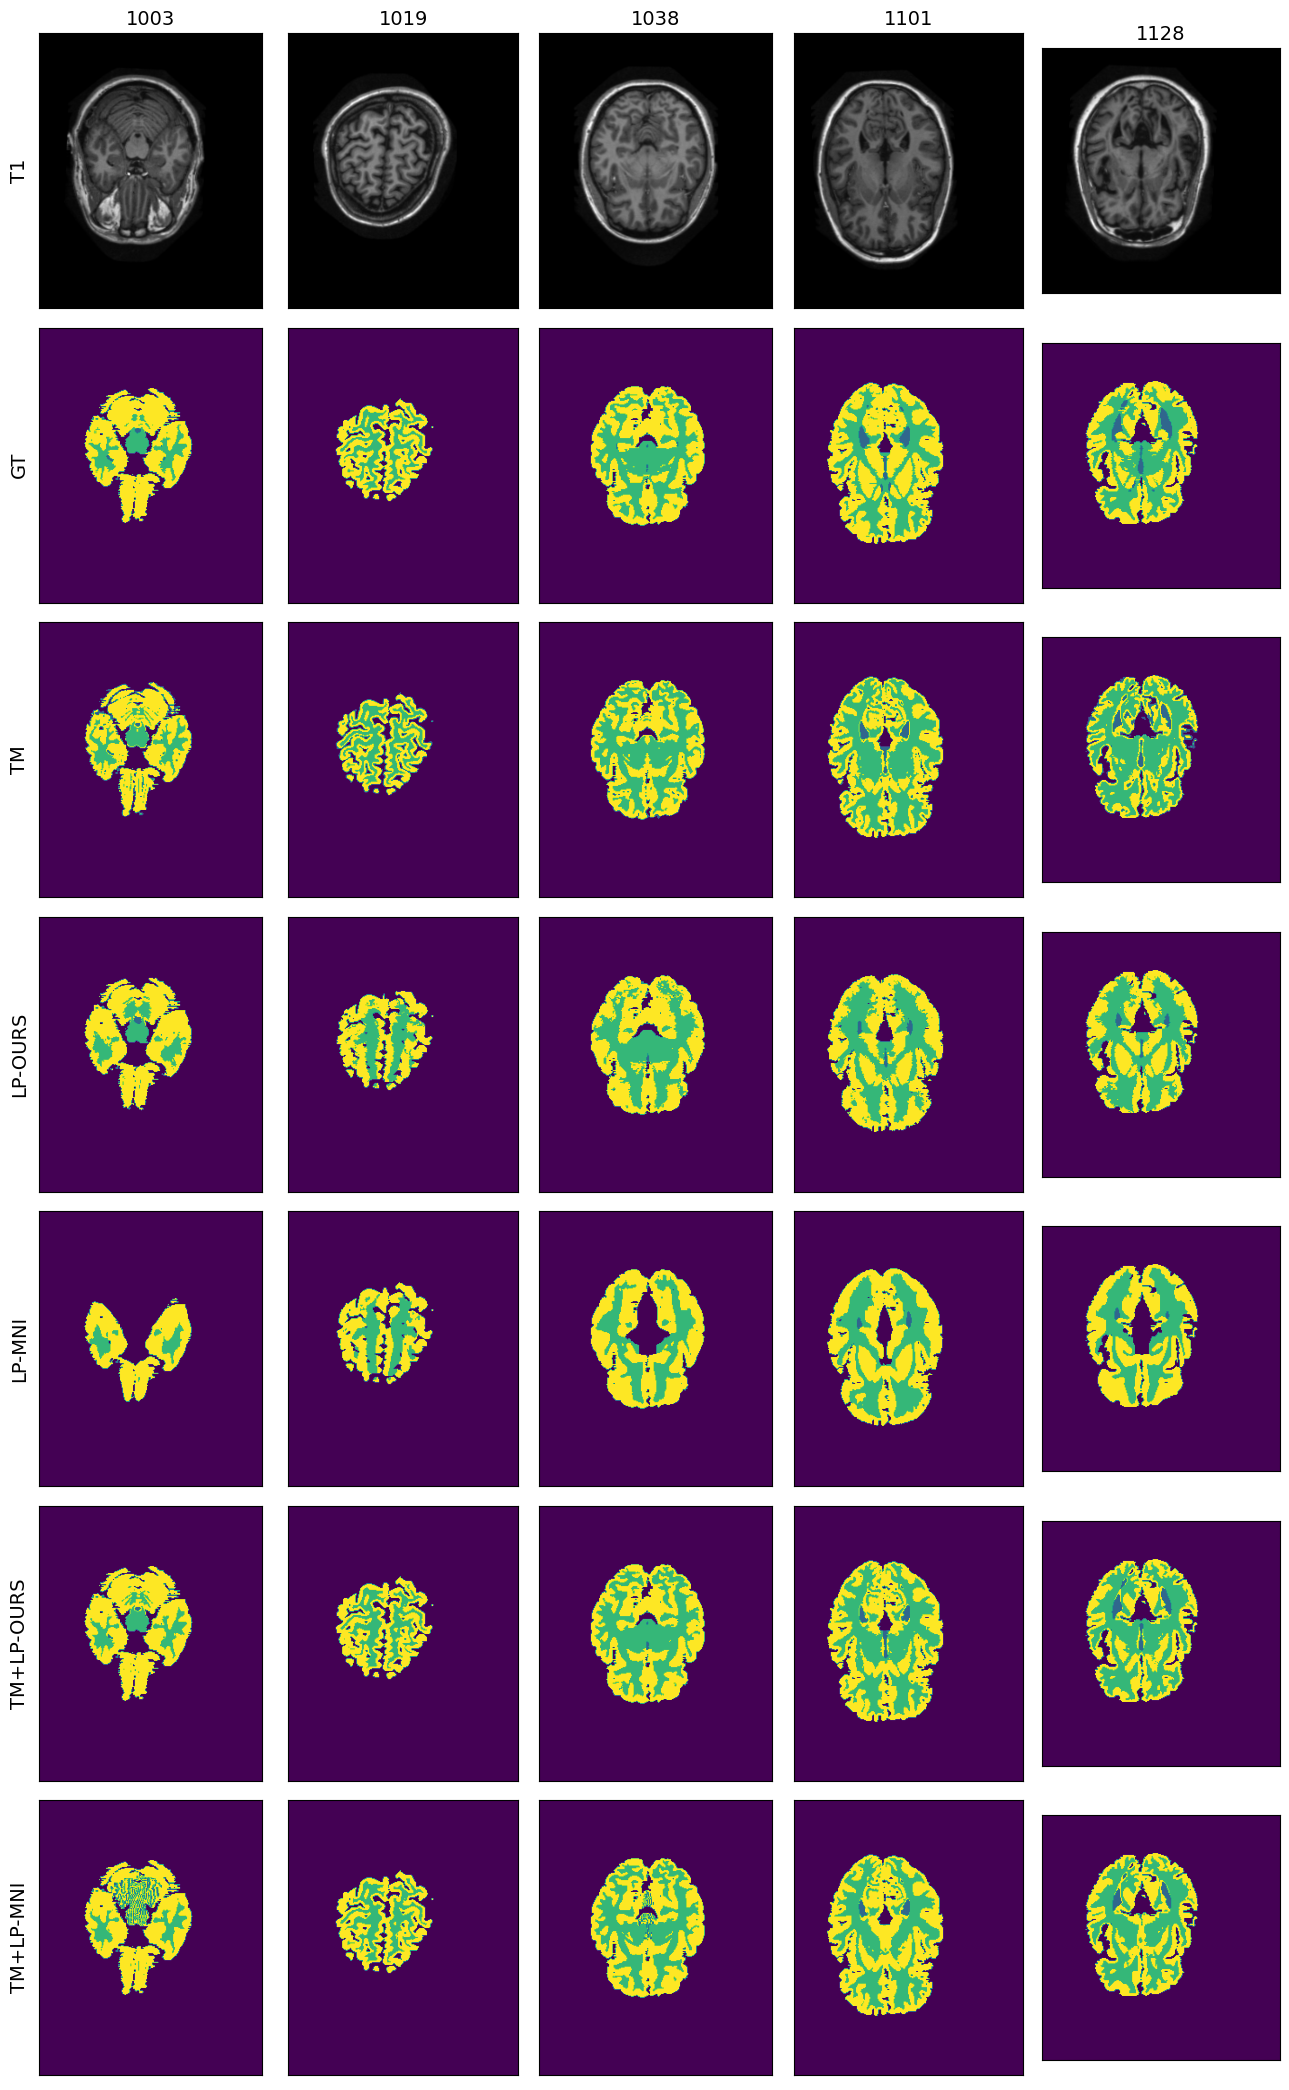

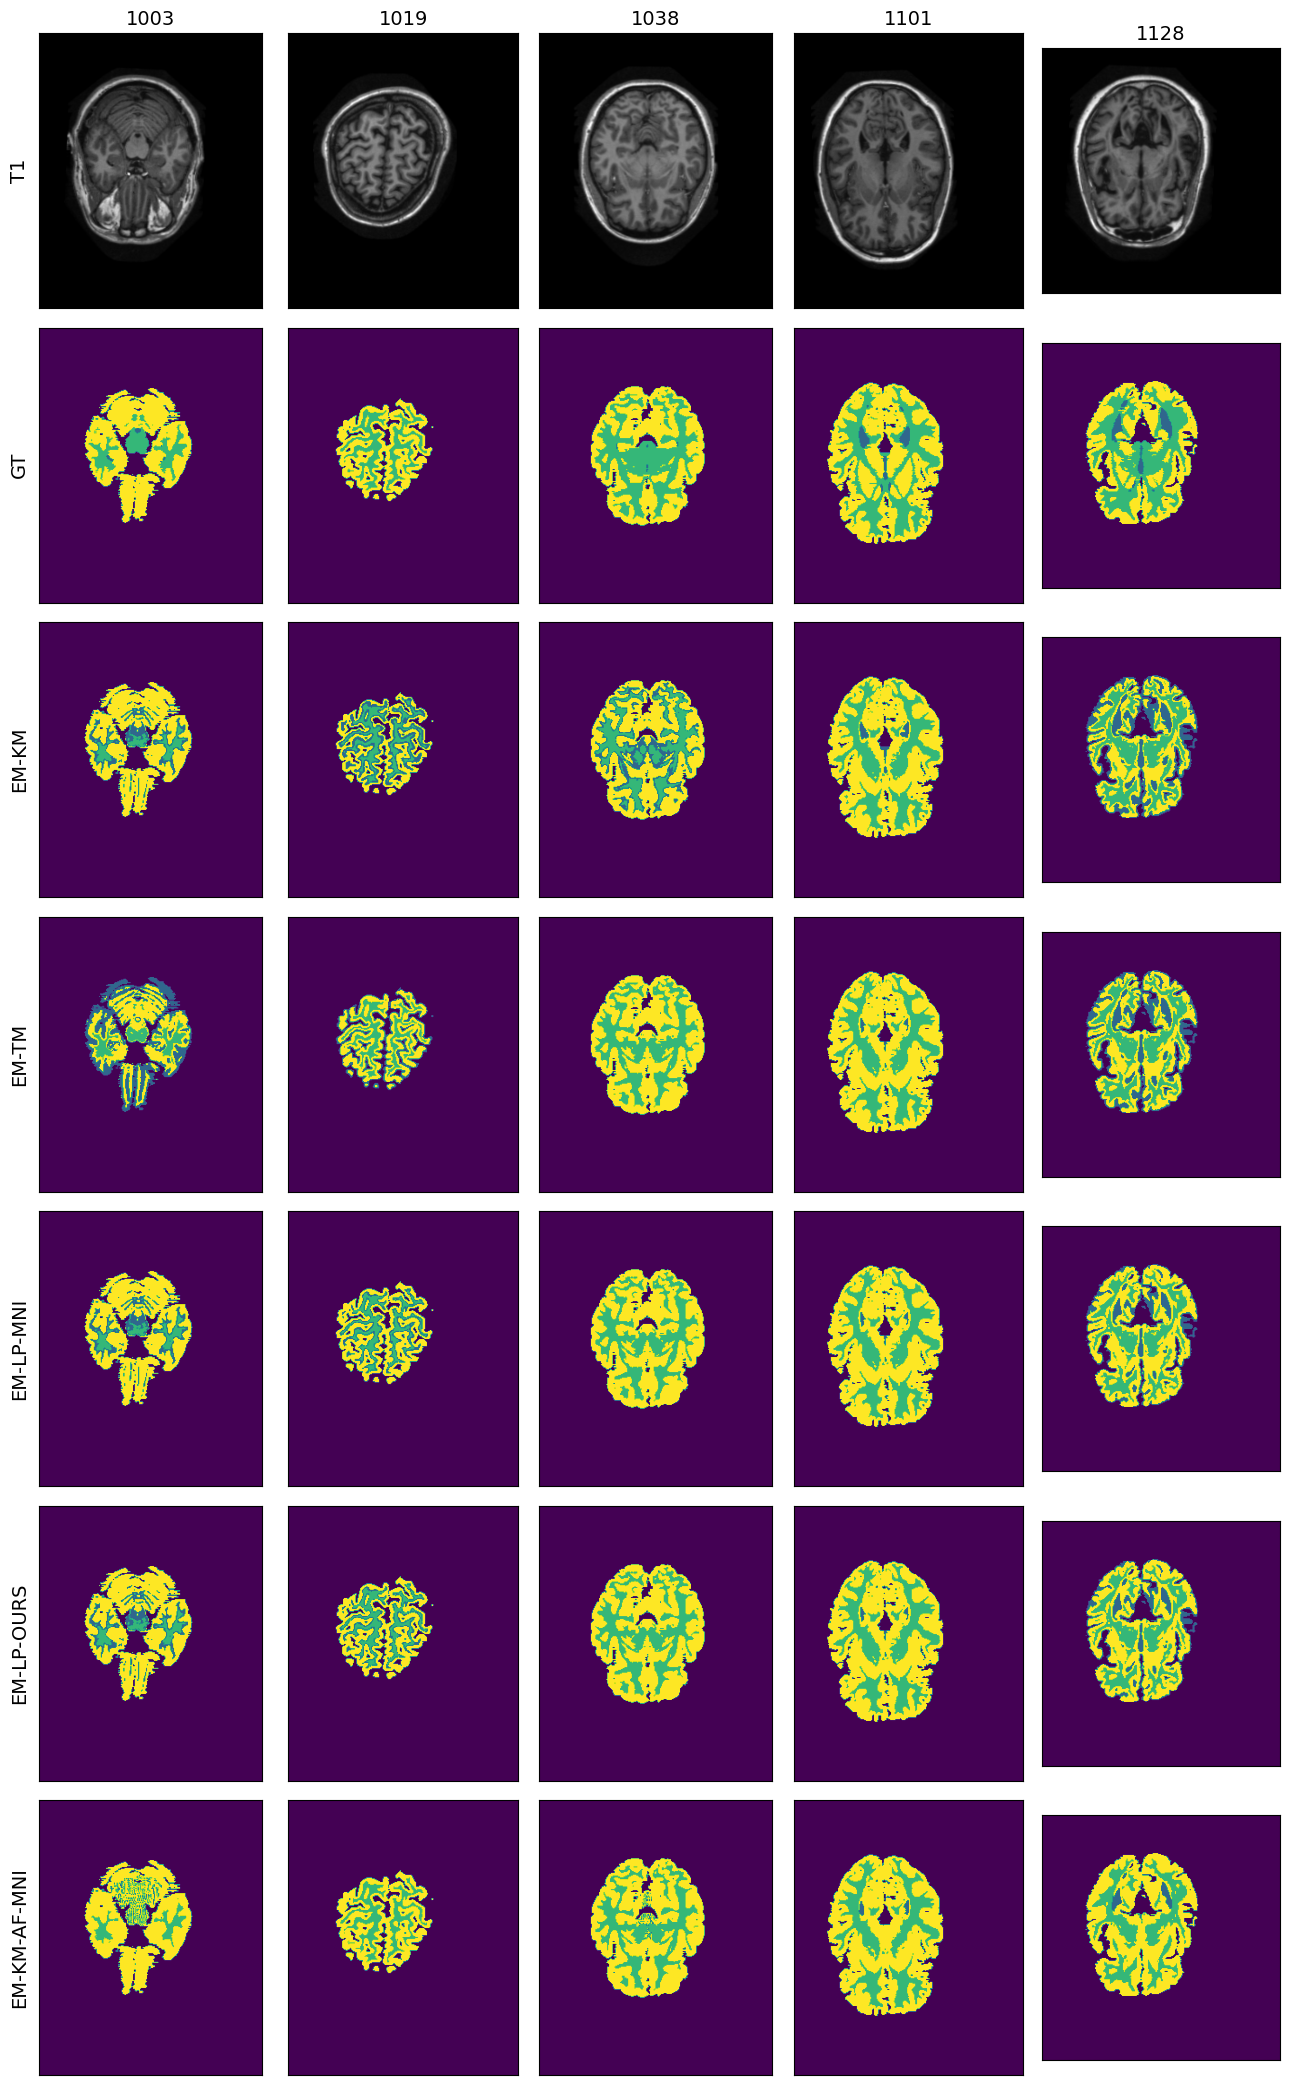

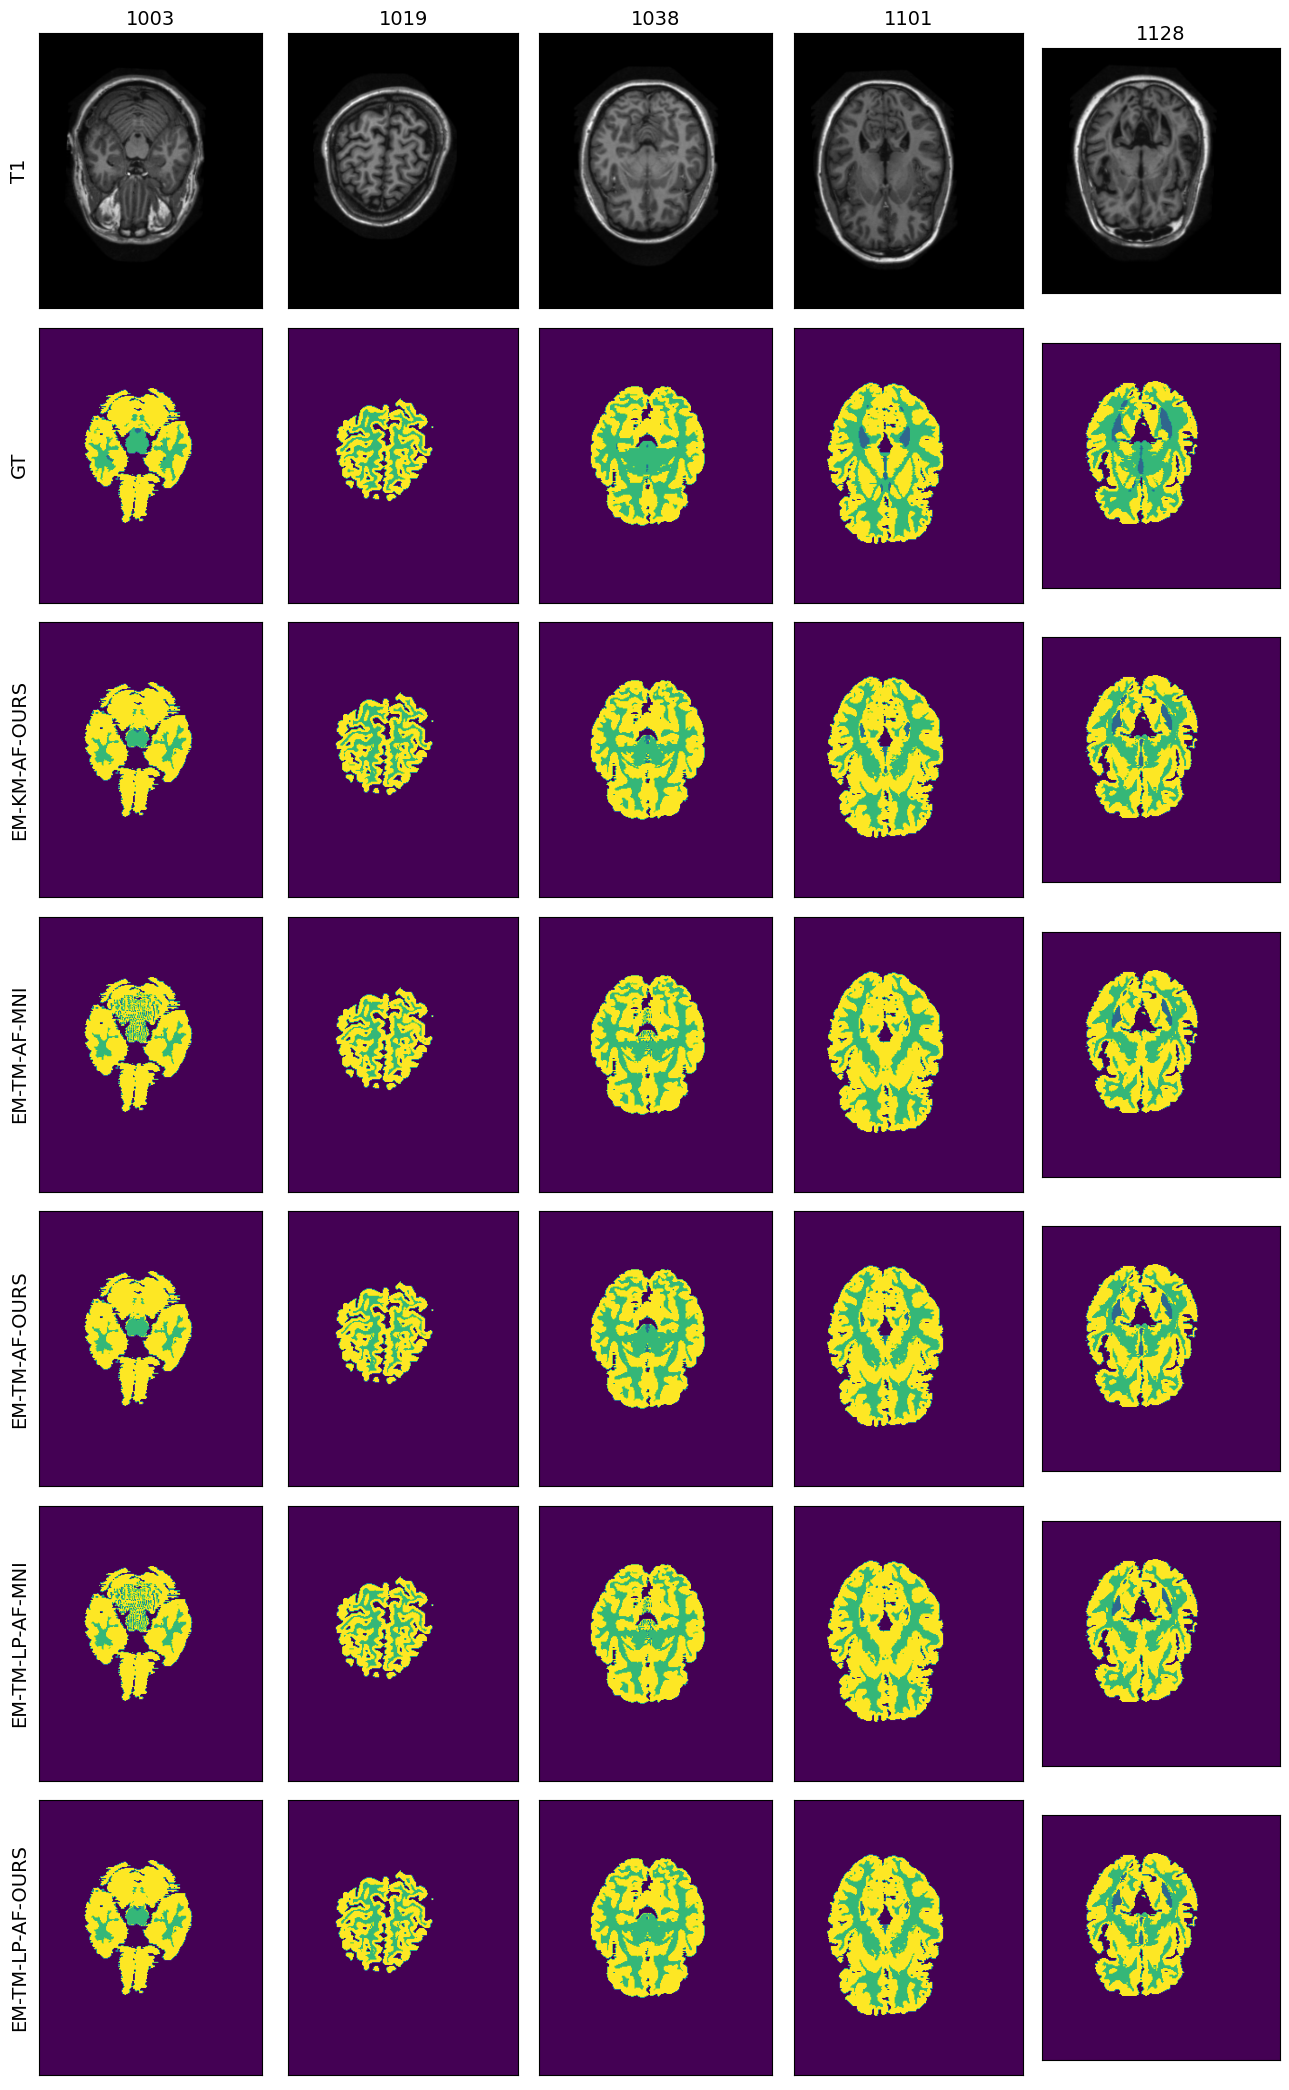

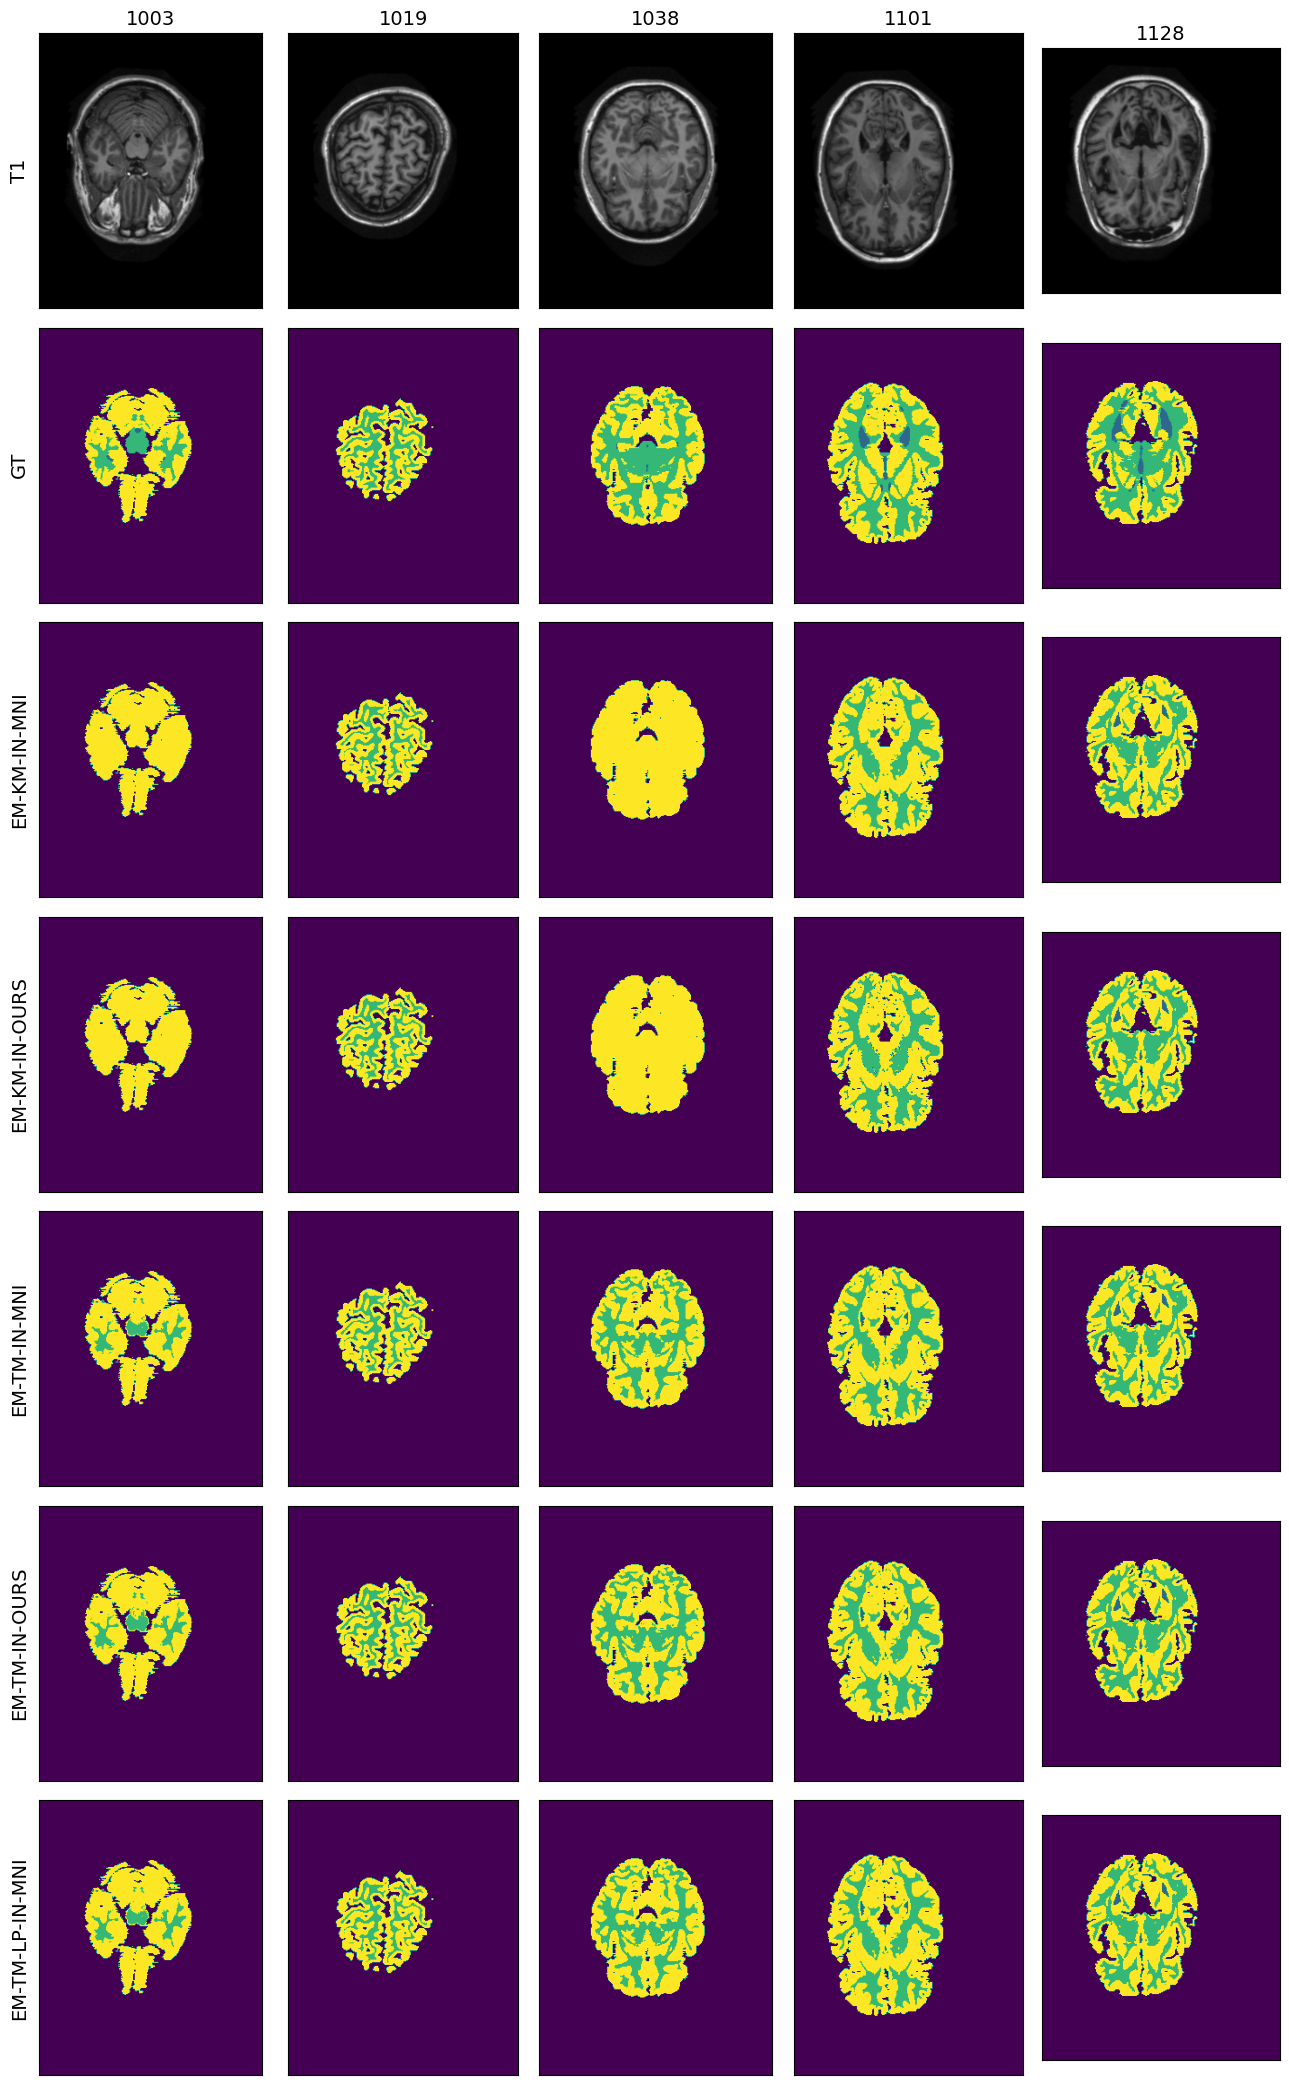

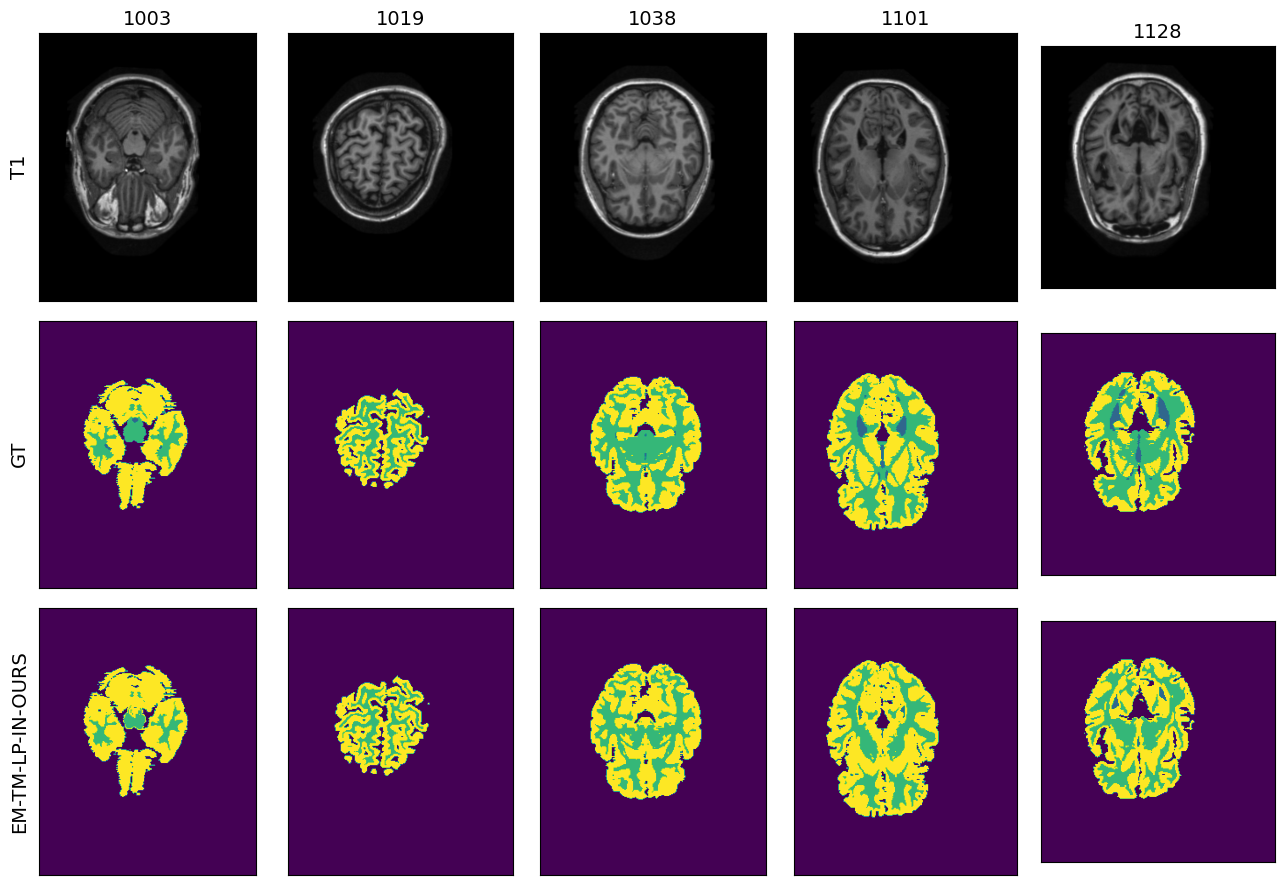

In [40]:
data_path = base_path / 'data' / 'lab3' / 'test-set'
img_path = data_path / 'testing-images'
labels_path = data_path / 'testing-labels'
segs_path = data_path / 'testing-segs'

algo_list = [
    'tm', 'lp_ours', 'lp_mni', 'tm+lp_ours', 'tm+lp_mni',
    'em_km', 'em_tm', 'em_lp_mni', 'em_lp_ours',
    'em_km_af_mni', 'em_km_af_ours', 'em_tm_af_mni', 'em_tm_af_ours',
    'em_tm_lp_af_mni', 'em_tm_lp_af_ours', 'em_km_in_mni', 'em_km_in_ours',
    'em_tm_in_mni', 'em_tm_in_ours', 'em_tm_lp_in_mni', 'em_tm_lp_in_ours'
]

cases = ['1003', '1019', '1038', '1101', '1128']
savepath = data_path / 'report-imgs'
savepath.mkdir(exist_ok=True, parents=True)
utils.complete_figure(img_path, labels_path, segs_path, cases, algo_list, slice_n = 125, savepath=savepath)

### Merge dice results boxplots

In [22]:
dices = []
for i in range(19):
    dices.append(pd.read_csv( base_path / 'lab3' / f'dice_scores_part_{i}.csv', index_col=0))
dice_scores = pd.concat(dices, ignore_index=True)

dice_scores['model'] = dice_scores.algorithm.str[:2]
dice_scores.to_csv('dice_scores.csv')

dice_scores = pd.read_csv('dice_scores.csv', index_col=0)

### Get analysis boxplots

In [41]:
import seaborn as sns

In [52]:
dice_scores = pd.read_csv('dice_scores.csv', index_col=0)
df = pd.melt(dice_scores, id_vars=['case', 'algorithm', 'time', 'iterations', 'init', 'atlas', 'atlas_use', 'model'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Case', 'Algorithm', 'Time', 'Iterations', 'Init', 'Atlas', 'Atlas_use', 'Model', 'Tissue', 'Dice']

### NON-EM Methods

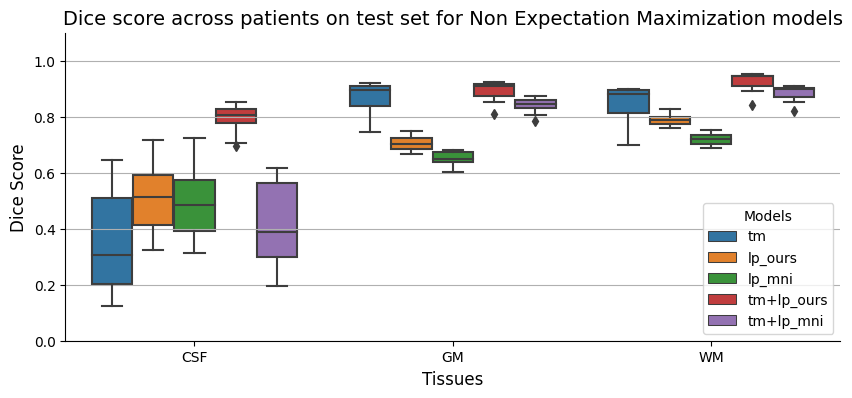

In [53]:
savepath = data_path / 'report-imgs'
savepath.mkdir(exist_ok=True, parents=True)

df_temp = df.loc[df.Model != 'EM']
plt.figure(figsize=(10,4))
plt.title('Dice score across patients on test set for Non Expectation Maximization models', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_1.svg', bbox_inches='tight', format='svg')
plt.show()

In [54]:
table = df_temp[['Algorithm', 'Tissue', 'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Algorithm', 'Tissue', 'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
table = table.round(4)
table.to_csv(str(savepath/'table_1.csv'))
table

mean_dice std_dice
Tissue Algorithm                    
CSF    lp_mni        0.4952   0.1180
       lp_ours       0.5092   0.1212
       tm            0.3540   0.1718
       tm+lp_mni     0.4089   0.1484
       tm+lp_ours    0.7967   0.0424
GM     lp_mni        0.6514   0.0237
       lp_ours       0.7036   0.0244
       tm            0.8721   0.0531
       tm+lp_mni     0.8432   0.0232
       tm+lp_ours    0.8956   0.0301
WM     lp_mni        0.7208   0.0201
       lp_ours       0.7899   0.0199
       tm            0.8526   0.0557
       tm+lp_mni     0.8889   0.0236
       tm+lp_ours    0.9295   0.0282

### EM methods different inits

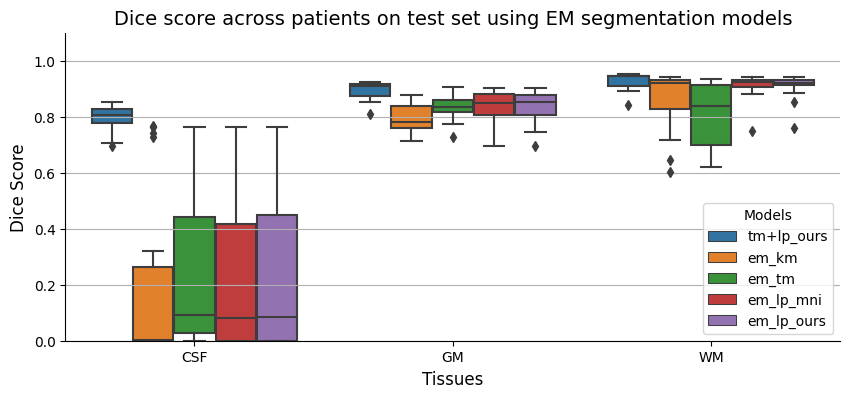

In [67]:
df_temp = df.loc[((df.Model == 'EM') & (df.Atlas_use == '-')) | (df.Algorithm == 'tm+lp_ours'), :]
plt.figure(figsize=(10, 4))
plt.title('Dice score across patients on test set using EM segmentation models', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_2.svg', bbox_inches='tight', format='svg')
plt.show()

In [56]:
table = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
df_temp['Iterations'] = df_temp['Iterations'].astype('int')
table['mean_iter'] = df_temp[['Algorithm', 'Tissue', 'Iterations']].groupby(['Tissue', 'Algorithm']).mean().Iterations.values
table['std_iter'] = df_temp[['Algorithm', 'Tissue', 'Iterations']].groupby(['Tissue', 'Algorithm']).std().Iterations.values
table = table.round(4)
table['mean_iter'] = table['mean_iter'].round().astype('int')
table['std_iter'] = table['std_iter'].round().astype('int')
table.to_csv(str(savepath/'table_2.csv'))

table

C:\Users\kaout\AppData\Local\Temp\ipykernel_22888\4241300668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Iterations'] = df_temp['Iterations'].astype('int')


mean_dice std_dice mean_iter std_iter
Tissue Algorithm                                       
CSF    em_km         0.2015   0.2992       291       29
       em_lp_mni     0.2271   0.2759       275       54
       em_lp_ours    0.2420   0.2927       260       65
       em_tm         0.2542   0.2797       280       41
GM     em_km         0.7961   0.0521       291       29
       em_lp_mni     0.8364   0.0575       275       54
       em_lp_ours    0.8364   0.0567       260       65
       em_tm         0.8325   0.0396       280       41
WM     em_km         0.8668   0.1009       291       29
       em_lp_mni     0.9121   0.0419       275       54
       em_lp_ours    0.9120   0.0415       260       65
       em_tm         0.8021   0.1156       280       41

### EM + Atlas After

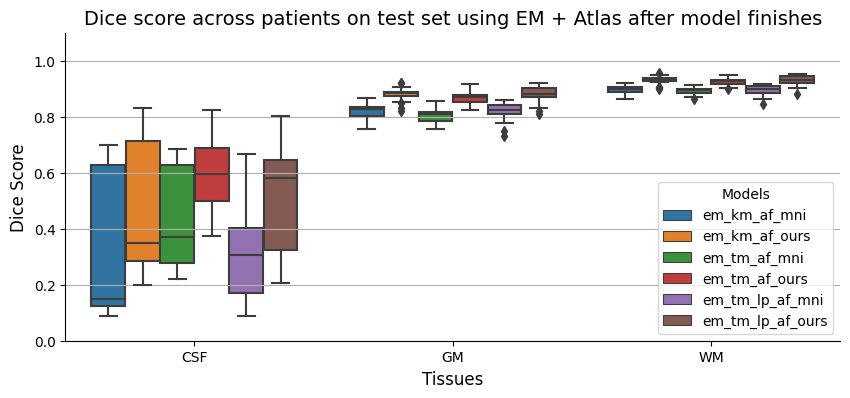

In [57]:
selection = ['em_km_af_mni', 'em_km_af_ours', 'em_tm_af_mni', 'em_tm_af_ours', 'em_tm_lp_af_mni', 'em_tm_lp_af_ours']
df_temp = df.loc[df.Algorithm.isin(selection), :]
plt.figure(figsize=(10, 4))
plt.title('Dice score across patients on test set using EM + Atlas after model finishes', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_3.svg', bbox_inches='tight', format='svg')
plt.show()

In [58]:
table = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
table = table.round(4)
table.to_csv(str(savepath/'table_3.csv'))
table

mean_dice std_dice
Tissue Algorithm                          
CSF    em_km_af_mni        0.3322   0.2601
       em_km_af_ours       0.4735   0.2359
       em_tm_af_mni        0.4247   0.1739
       em_tm_af_ours       0.5972   0.1326
       em_tm_lp_af_mni     0.3239   0.1947
       em_tm_lp_af_ours    0.5046   0.1848
GM     em_km_af_mni        0.8193   0.0296
       em_km_af_ours       0.8789   0.0254
       em_tm_af_mni        0.8031   0.0251
       em_tm_af_ours       0.8659   0.0231
       em_tm_lp_af_mni     0.8182   0.0348
       em_tm_lp_af_ours    0.8793   0.0313
WM     em_km_af_mni        0.8954   0.0168
       em_km_af_ours       0.9302   0.0139
       em_tm_af_mni        0.8907   0.0129
       em_tm_af_ours       0.9250   0.0123
       em_tm_lp_af_mni     0.8946   0.0193
       em_tm_lp_af_ours    0.9292   0.0181

### EM + Atlas after selection

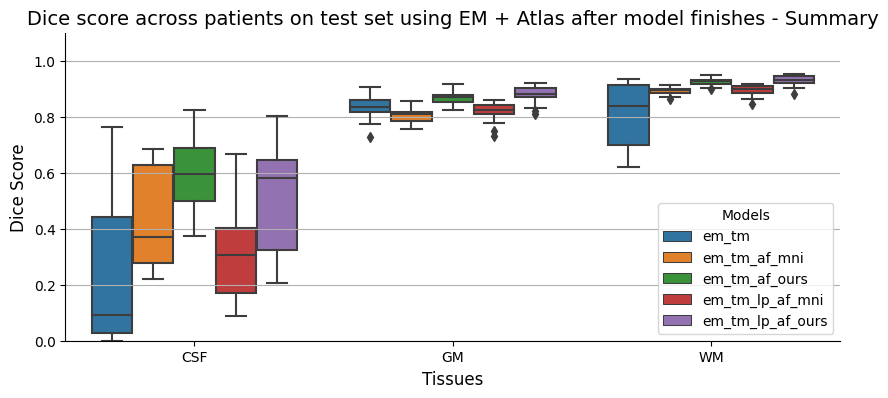

In [59]:
selection = ['em_tm', 'em_tm_af_mni', 'em_tm_af_ours', 'em_tm_lp_af_mni', 'em_tm_lp_af_ours']
df_temp = df.loc[df.Algorithm.isin(selection), :]
plt.figure(figsize=(10, 4))
plt.title('Dice score across patients on test set using EM + Atlas after model finishes - Summary', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_4.svg', bbox_inches='tight', format='svg')
plt.show()

In [60]:
table = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
table = table.round(4)
table.to_csv(str(savepath/'table_4.csv'))

table

mean_dice std_dice
Tissue Algorithm                          
CSF    em_tm               0.2542   0.2797
       em_tm_af_mni        0.4247   0.1739
       em_tm_af_ours       0.5972   0.1326
       em_tm_lp_af_mni     0.3239   0.1947
       em_tm_lp_af_ours    0.5046   0.1848
GM     em_tm               0.8325   0.0396
       em_tm_af_mni        0.8031   0.0251
       em_tm_af_ours       0.8659   0.0231
       em_tm_lp_af_mni     0.8182   0.0348
       em_tm_lp_af_ours    0.8793   0.0313
WM     em_tm               0.8021   0.1156
       em_tm_af_mni        0.8907   0.0129
       em_tm_af_ours       0.9250   0.0123
       em_tm_lp_af_mni     0.8946   0.0193
       em_tm_lp_af_ours    0.9292   0.0181

### EM + Atlas into 

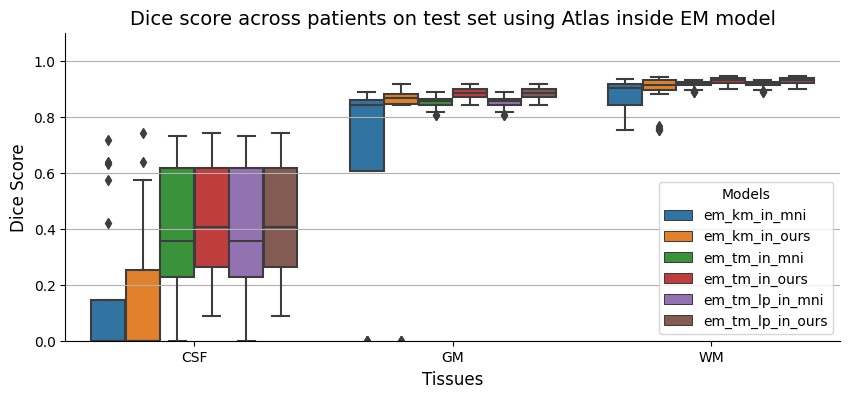

In [61]:
selection = ['em_km_in_mni', 'em_km_in_ours', 'em_tm_in_mni', 'em_tm_in_ours', 'em_tm_lp_in_mni', 'em_tm_lp_in_ours']
df_temp = df.loc[df.Algorithm.isin(selection), :]
plt.figure(figsize=(10, 4))
plt.title('Dice score across patients on test set using Atlas inside EM model', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_5.svg', bbox_inches='tight', format='svg')
plt.show()

In [62]:
table = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Tissue', 'Algorithm',  'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
df_temp['Iterations'] = df_temp['Iterations'].astype('int')
table['mean_iter'] = df_temp[['Algorithm', 'Tissue', 'Iterations']].groupby(['Tissue', 'Algorithm']).mean().Iterations.values
table['std_iter'] = df_temp[['Algorithm', 'Tissue', 'Iterations']].groupby(['Tissue', 'Algorithm']).std().Iterations.values
table = table.round(4)
table['mean_iter'] = table['mean_iter'].round().astype('int')
table['std_iter'] = table['std_iter'].round().astype('int')
table.to_csv(str(savepath/'table_5.csv'))

table

C:\Users\kaout\AppData\Local\Temp\ipykernel_22888\2379804458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Iterations'] = df_temp['Iterations'].astype('int')


mean_dice std_dice mean_iter std_iter
Tissue Algorithm                                             
CSF    em_km_in_mni        0.1536   0.2674       110       88
       em_km_in_ours       0.1683   0.2508       101       75
       em_tm_in_mni        0.3797   0.2546        84       23
       em_tm_in_ours       0.4216   0.2186        83       14
       em_tm_lp_in_mni     0.3779   0.2572       105       71
       em_tm_lp_in_ours    0.4216   0.2186        84       13
GM     em_km_in_mni        0.6356   0.3771       110       88
       em_km_in_ours       0.7002   0.3597       101       75
       em_tm_in_mni        0.8509   0.0228        84       23
       em_tm_in_ours       0.8818   0.0208        83       14
       em_tm_lp_in_mni     0.8509   0.0228       105       71
       em_tm_lp_in_ours    0.8818   0.0208        84       13
WM     em_km_in_mni        0.8712   0.0697       110       88
       em_km_in_ours       0.8874   0.0685       101       75
       em_tm_in_mni        0.9147   0.0135        84       23
       em_tm_in_ours       0.9267   0.0136        83       14
       em_tm_lp_in_mni     0.9147   0.0135       105       71
       em_tm_lp_in_ours    0.9267   0.0136        84       13

### EM + Atlas into - Selection

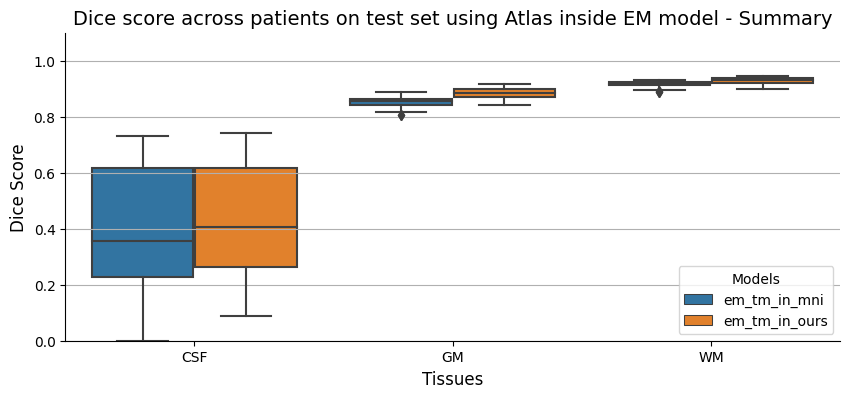

In [63]:
selection = ['em_tm_in_mni', 'em_tm_in_ours']
df_temp = df.loc[df.Algorithm.isin(selection), :]
plt.figure(figsize=(10, 4))
plt.title('Dice score across patients on test set using Atlas inside EM model - Summary', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_6.svg', bbox_inches='tight', format='svg')

plt.show()

In [64]:
table = df_temp[['Algorithm', 'Tissue', 'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Algorithm', 'Tissue', 'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
table.to_csv(str(savepath/'table_6.csv'))
table = table.round(4)
table

mean_dice std_dice
Tissue Algorithm                       
CSF    em_tm_in_mni     0.3797   0.2546
       em_tm_in_ours    0.4216   0.2186
GM     em_tm_in_mni     0.8509   0.0228
       em_tm_in_ours    0.8818   0.0208
WM     em_tm_in_mni     0.9147   0.0135
       em_tm_in_ours    0.9267   0.0136

## Best results comparisson

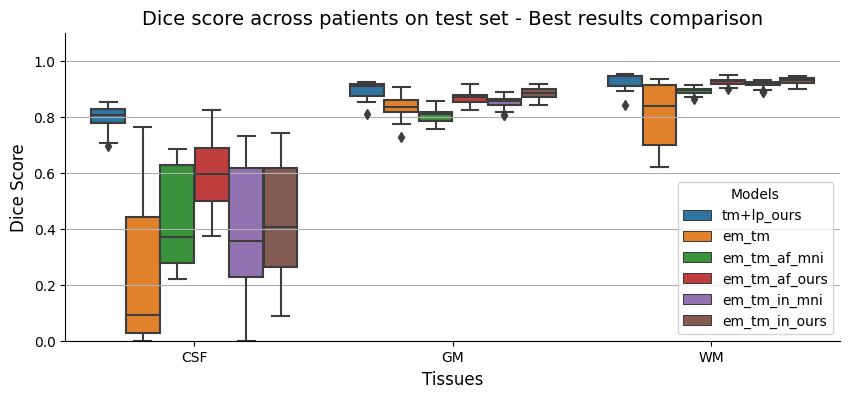

In [65]:
selection = ['tm+lp_ours', 'em_tm', 'em_tm_af_mni', 'em_tm_af_ours', 'em_tm_in_mni', 'em_tm_in_ours']
df_temp = df.loc[df.Algorithm.isin(selection), :]
plt.figure(figsize=(10, 4))
plt.title('Dice score across patients on test set - Best results comparison', fontsize=14)
sns.boxplot(data=df_temp, x="Tissue", y="Dice", hue="Algorithm")
sns.despine()
plt.grid(axis='y')
plt.ylim([0, 1.1])
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.savefig(savepath/f'boxplot_7.svg', bbox_inches='tight', format='svg')

plt.show()

In [66]:
table = df_temp[['Algorithm', 'Tissue', 'Dice']].groupby(['Tissue', 'Algorithm']).mean()
table.columns = [['mean_dice']]
table['std_dice'] = df_temp[['Algorithm', 'Tissue', 'Dice']].groupby(['Tissue', 'Algorithm']).std().Dice.values
table = table.round(4)
table.to_csv(str(savepath/'table_7.csv'))
table

mean_dice std_dice
Tissue Algorithm                       
CSF    em_tm            0.2542   0.2797
       em_tm_af_mni     0.4247   0.1739
       em_tm_af_ours    0.5972   0.1326
       em_tm_in_mni     0.3797   0.2546
       em_tm_in_ours    0.4216   0.2186
       tm+lp_ours       0.7967   0.0424
GM     em_tm            0.8325   0.0396
       em_tm_af_mni     0.8031   0.0251
       em_tm_af_ours    0.8659   0.0231
       em_tm_in_mni     0.8509   0.0228
       em_tm_in_ours    0.8818   0.0208
       tm+lp_ours       0.8956   0.0301
WM     em_tm            0.8021   0.1156
       em_tm_af_mni     0.8907   0.0129
       em_tm_af_ours    0.9250   0.0123
       em_tm_in_mni     0.9147   0.0135
       em_tm_in_ours    0.9267   0.0136
       tm+lp_ours       0.9295   0.0282